# Sediment erosion and Transport from 

In this notebook we implement the erosion and sediment transport components of the matlab model (Mariotti and Murshid, 2018) in the existing landlab tidal flow version.

## Importing and Installing

First we will import some standard scientific Python libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Next we need to install some Landlab libraries to properly accomplish this task

As of this writing (8/18/2020) the tidal-flow-calculator is not part of the core Landlab installation. As a consequence, we need to checkout the feature branch containing the tidal-flow-calculator component (https://github.com/landlab/landlab/tree/gt/tidal-flow-component). After checking out or cloning this branch locally, python setup.py install should be run to build a new landlab installation containing the tidal-flow-calculator.

We convert the matlab fuctions (totalsedimenterosionMUDsine.m and sedtran.m) from Mariotti and Murshid ( 2018) to python (tidal_erosion_calculator) to calculate total sediment erosion. 

In [2]:
from landlab.grid.mappers import map_link_vector_components_to_node
from landlab import RasterModelGrid, imshow_grid
from landlab.components import TidalFlowCalculator
from landlab.grid.mappers import map_max_of_link_nodes_to_link
from landlab.io import read_esri_ascii
import tidal_erosion_calculator as tec

## Set parameters 

In [3]:
#This set-up is from the MarshMorpho2D source code
tidal_period = 12.5 * 3600.0  # tidal period in seconds
tidal_range = 3.1  # tidal range in meters
roughness_w = 0.02  # Manning's n water
roughness_v = 0.2 #manning's n for veg
mean_sea_level = 0.0  # mean sea level in meters
mwd = 0.01  # minimum depth for water on areas higher than low tide water surface, meters
nodata_code = 999  # code for a DEM cell with no valid data

### Read the DEM to create a grid and topography field

The zSW3.asc dataset can be found at: https://raw.githubusercontent.com/landlab/landlab/gt/tidal-flow-component/notebooks/tutorials/tidal_flow/zSW3.asc

In [4]:
(grid, z) = read_esri_ascii('/Users/ningjiehu/zSW3.asc.txt', name='topographic__elevation')

### Create vegetation grid

In [5]:
veg = grid.add_zeros('vegetation',at='node');
veg[z<0] = 1;
veg_atlink = grid.map_max_of_link_nodes_to_link('vegetation')
grid.add_field('veg_atlink',veg_atlink,at='link')

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

### Configure boundaries

The boundaries contains any nodata nodes, plus any nodes higher than mean high tide

In [6]:
grid.status_at_node[z==nodata_code] = grid.BC_NODE_IS_CLOSED
grid.status_at_node[z>1.8] = grid.BC_NODE_IS_CLOSED
boundaries_above_msl = np.logical_and(grid.status_at_node==grid.BC_NODE_IS_FIXED_VALUE, z > 0.0)
grid.status_at_node[boundaries_above_msl] = grid.BC_NODE_IS_CLOSED

print('pre tfc:')
print(grid.at_node.keys())
print(grid.at_link.keys())

pre tfc:
['topographic__elevation', 'vegetation']
['veg_atlink']


### Generate variable rougness as field in grid

In [7]:
roughness_at_nodes = roughness_w + np.zeros(z.size)
roughness_at_nodes[z < 0.0] = roughness_v #or roughness_at_nodes[veg] = roughness_v
roughness = grid.add_zeros('roughness', at='link')
map_max_of_link_nodes_to_link(grid, roughness_at_nodes, out=roughness)

array([ 0.02,  0.02,  0.02, ...,  0.02,  0.02,  0.02])

## Instantiate a TidalFlowCalculator component

In [8]:
tfc = TidalFlowCalculator(
        grid,
        tidal_period=tidal_period,
        tidal_range=tidal_range,
        roughness='roughness',
        mean_sea_level=mean_sea_level,
        min_water_depth=mwd,
)

### Assign critical shear stress (?)

In [9]:
tau_cr = 0.2 #Critical stress for unvegetated areas
tau_crv = 0.5  #Critical stress for vegetated areas

In [10]:
v = grid.at_link['veg_atlink']
tec.populateGrids(grid,tfc,tau_cr,tau_crv,v)
print(grid.at_cell.keys())
print(grid.at_node.keys())

['tidal_innundation_rate_cell', 'effective_water_depth_cell', 'topographic_elevation_cell', 'hydroperiod_cell', 'water_depth_at_MHW_cell', 'lev_at_cell', 'tau_cr_cell', 'ebb_tide_flow__velocity_cell', 'flood_tide_flow__velocity_cell', 'roughness_cell', 'water_depth_at_cell']
['topographic__elevation', 'vegetation', 'mean_water__depth', 'tidal_innundation_rate', 'effective_water_depth', 'hydroperiod', 'water_depth_at_MHW', 'lev_at_node', 'tau_cr_node', 'ebb_tide_flow__velocity_node', 'flood_tide_flow__velocity_node', 'roughness_node', 'water_depth_at_node']


### Plot tidal flow

/Users/ningjiehu/landlab/landlab/plot/imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("YlGnBu"))
  cmap.set_bad(color=color_for_closed)
/Users/ningjiehu/landlab/landlab/plot/imshow.py:307: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)
/Users/ningjiehu/landlab/landlab/plot/imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("

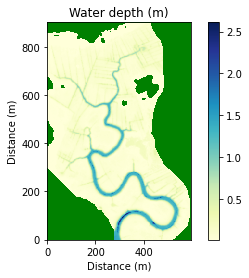

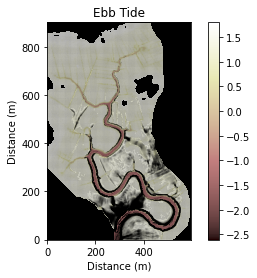

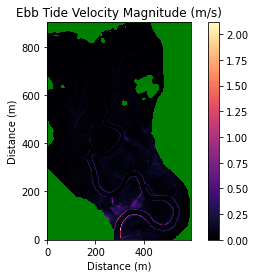

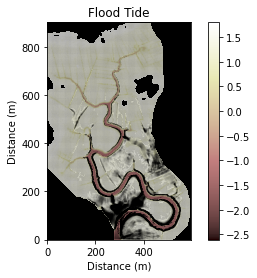

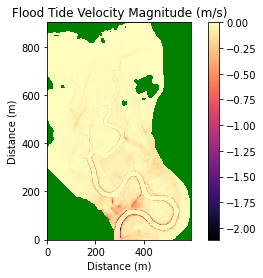

In [11]:
tec.plot_tidal_flow(grid)

## Consider erosion

### Set mud erodability

In [12]:
mud_erodability = (10**-5)*24*3600;  # mud erodability kg/m2/day!!!

In [13]:
ero = tec.totalsedimenterosion_mudsine(grid, mud_erodability)
#ok so for some reason erosion value is SUPER high -- no clue why...need to clear that up!

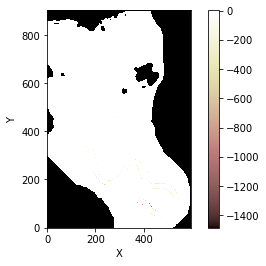

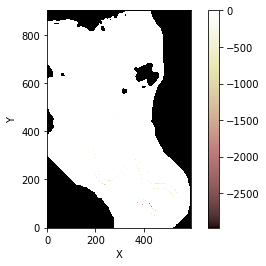

In [14]:
for i in range(2):
    ero = tec.totalsedimenterosion_mudsine(grid, mud_erodability)
    z = grid.at_node['topographic__elevation']
    z -= ero
    tfc.run_one_step()
    plt.figure()
    imshow_grid(grid,grid.at_node['topographic__elevation'])
    